## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [717]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

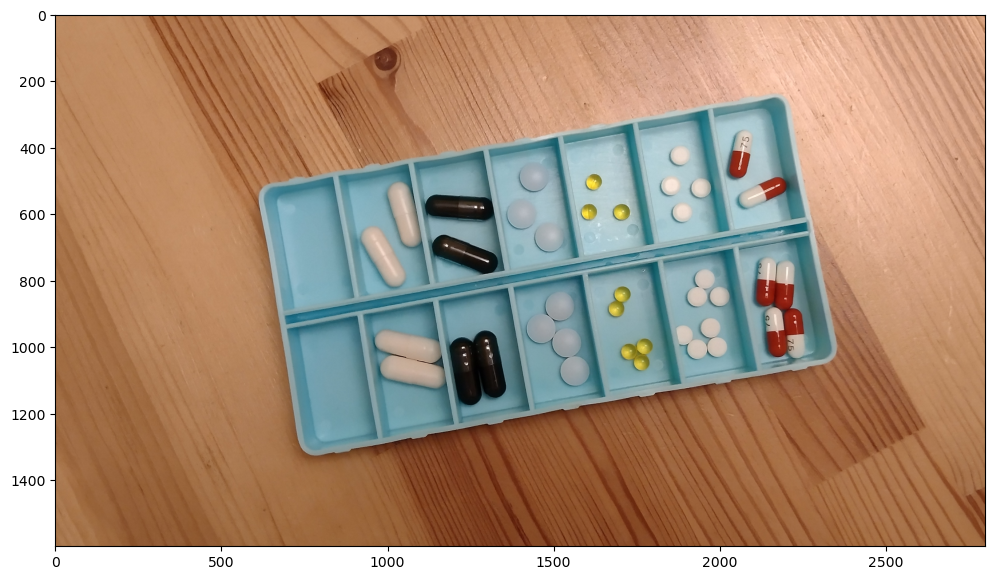

In [718]:
calib = cv2.imread('Lab5_dane/calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [719]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

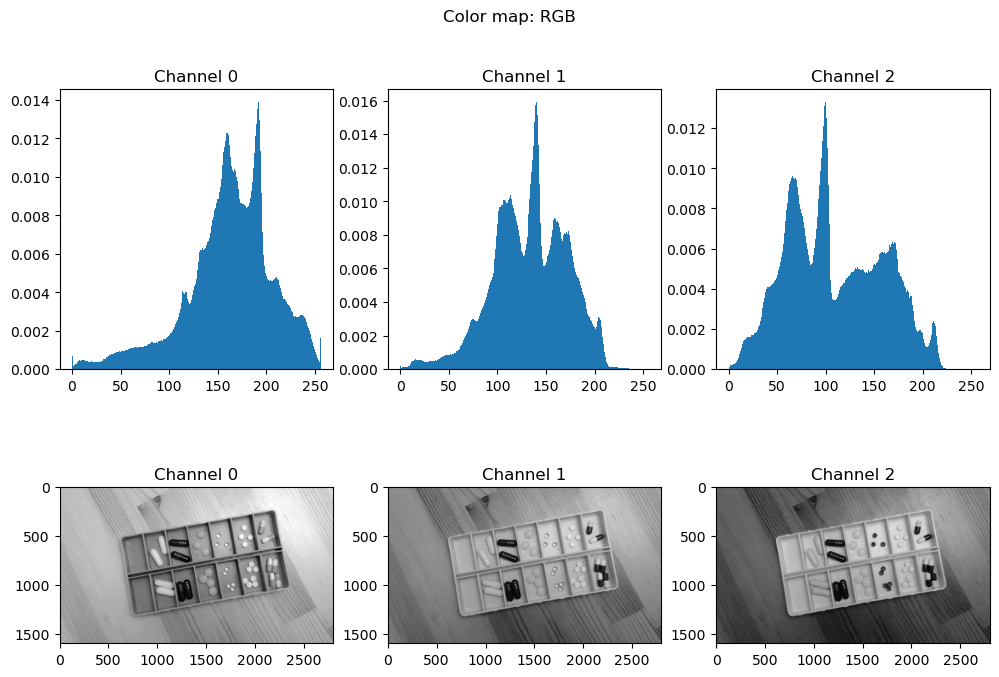

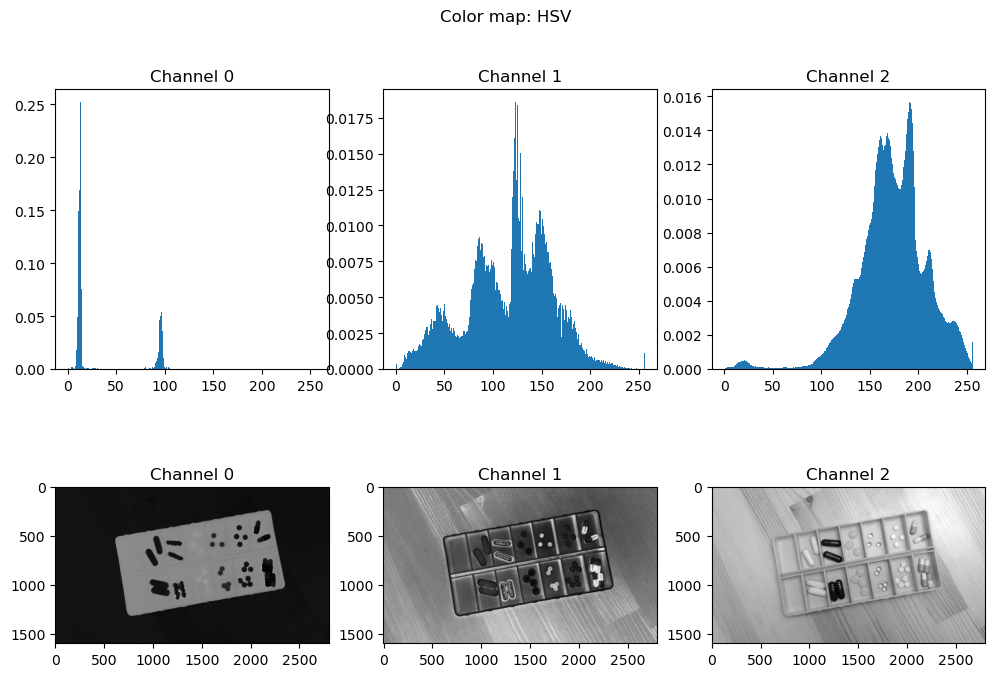

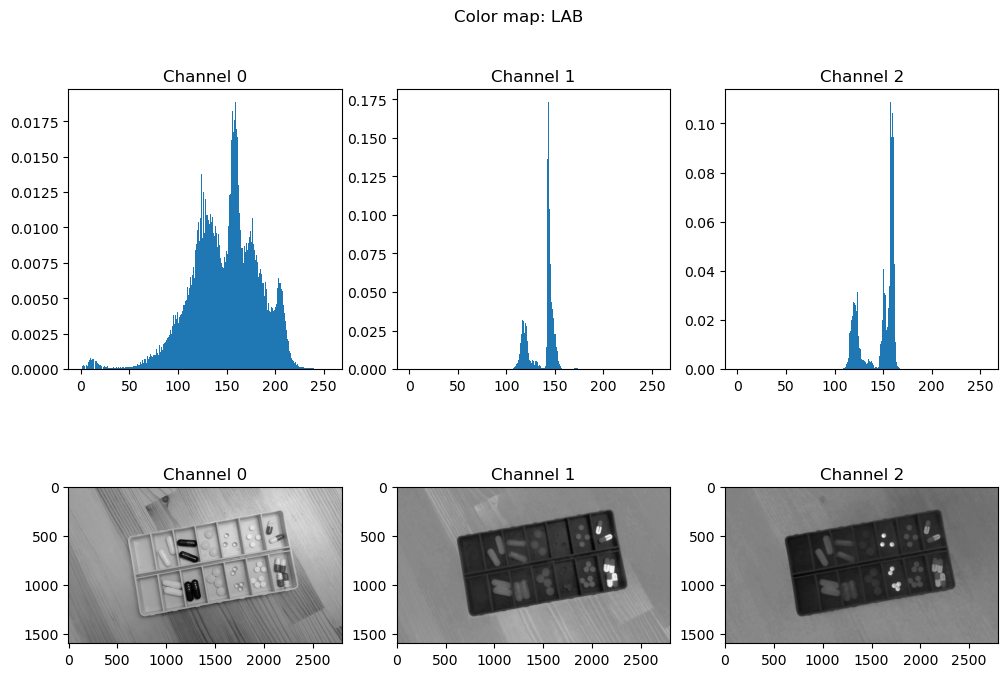

In [720]:
def print_hist_and_chanels(img: np.ndarray, color_map=cv2.COLOR_BGR2HSV, name: str = None) -> None: 
    img = cv2.cvtColor(img, color_map)
    fig, axs = plt.subplots(2, 3, figsize=(12,8))
    
    for idx, channel in enumerate(cv2.split(img)):
        axs[0, idx].hist(channel.ravel(), bins=256, range=(0, 256), density=True)
        axs[0, idx].set_title(f'Channel {idx}')
        axs[1, idx].imshow(channel, cmap='gray')
        axs[1, idx].set_title(f'Channel {idx}')

    fig.suptitle(f'Color map: {name}')
    plt.show()

print_hist_and_chanels(calib, cv2.COLOR_BGR2RGB, 'RGB')
print_hist_and_chanels(calib, cv2.COLOR_BGR2HSV, 'HSV')
print_hist_and_chanels(calib, cv2.COLOR_BGR2LAB, 'LAB')

# EPSU

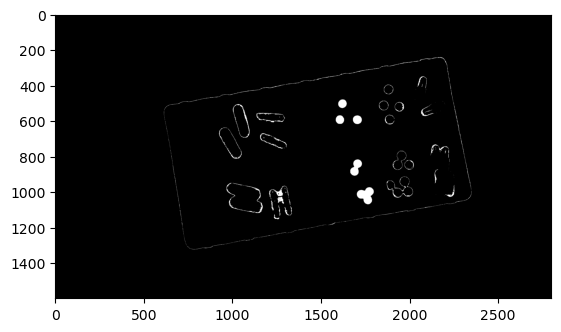

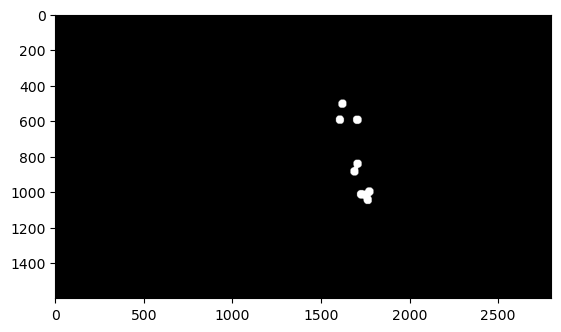

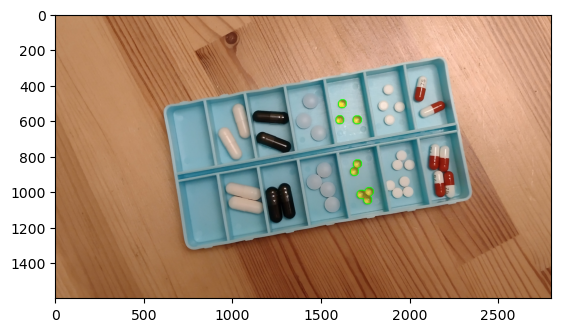

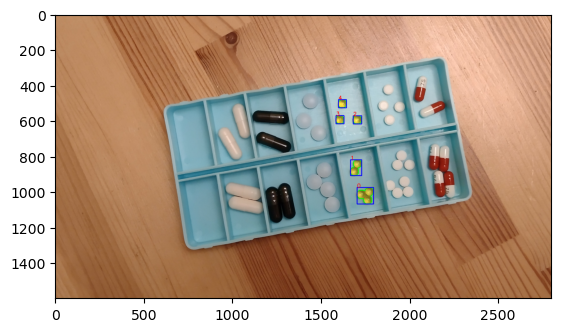

In [721]:
image = calib.copy()
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h = hsv[..., 0]

yellow = cv2.inRange(h, 20, 40)
plt.imshow(yellow, cmap='gray')
plt.show()
yellow = cv2.morphologyEx(yellow, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=8)
plt.imshow(yellow, cmap='gray')
plt.show()
conts, _ = cv2.findContours(yellow, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

pills = [c for c in conts if cv2.contourArea(c) > 1000]

cv2.drawContours(image, pills, -1, (0, 255, 0), 3)
plt.imshow(image[..., ::-1])
plt.show()

pills = [cv2.boundingRect(c) for c in pills]

for i, (x, y, w, h) in enumerate(pills):
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)
    cv2.putText(image, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.imshow(image[..., ::-1])
plt.show()


# GET CIRCLES

[[[1608  594   23]
  [1708  842   24]
  [1622  506   23]
  [1706  594   25]
  [1688  886   23]
  [1766 1048   24]
  [1726 1014   23]
  [1776  998   22]]]


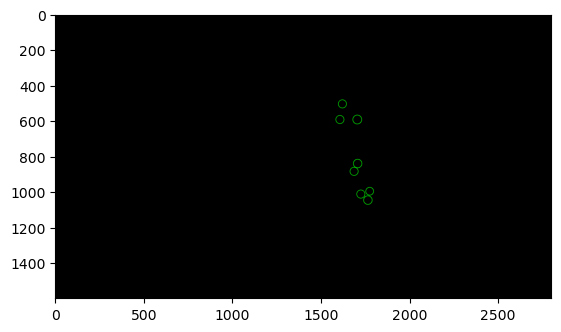

In [722]:
def find_circles(img: np.ndarray, min_radius: int = 0, max_radius: int = 0) -> List[Any]:
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=10,minRadius=min_radius,maxRadius=max_radius)
    return np.uint16(np.around(circles))


circles = find_circles(yellow, 10, 27)
circles = np.uint16(np.around(circles))

print(circles)

image = np.zeros_like(calib)

for i in circles[0, :]:
    cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
plt.imshow(image[..., ::-1])

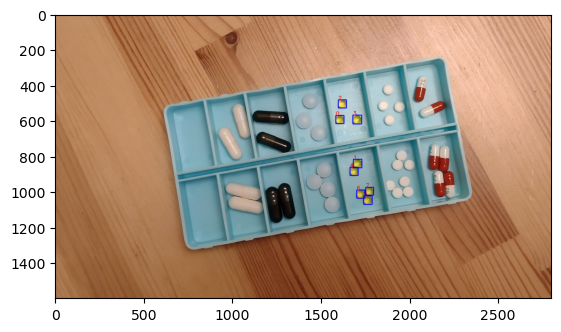

In [723]:
pills = [(x - r, y - r, 2*r, 2*r) for x, y, r in circles[0]]

image = calib.copy()
for i, (x, y, w, h) in enumerate(pills):
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)
    cv2.putText(image, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.imshow(image[..., ::-1])


# BIOX

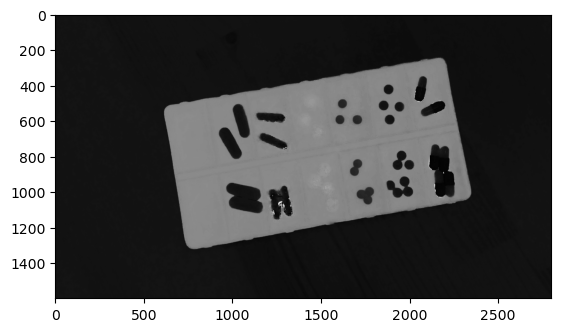

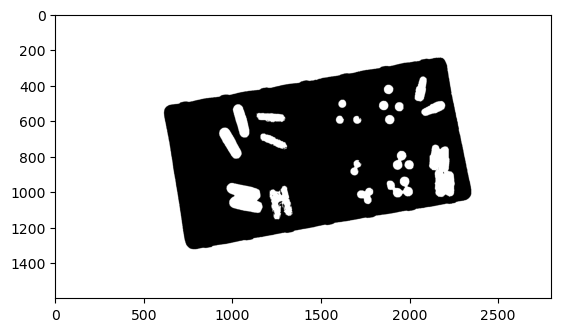

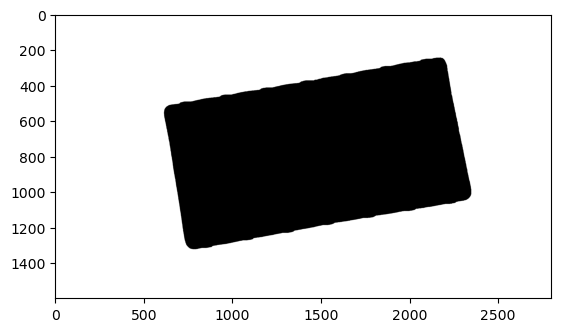

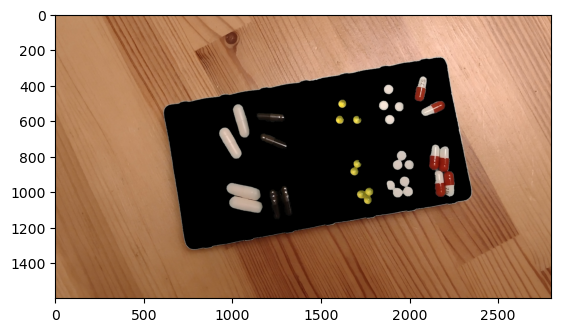

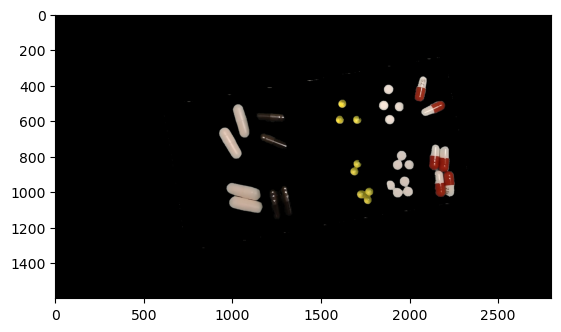

In [724]:
image = calib.copy()
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h = hsv[..., 0]

plt.imshow(h, cmap='gray')
plt.show()

_, mask = cv2.threshold(h, 30, 255, cv2.THRESH_BINARY_INV)
plt.imshow(mask, cmap='gray')
plt.show()

# find countour of the black to crop the image

mask_only_box = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((11, 11), np.uint8), iterations=22)

plt.imshow(mask_only_box, cmap='gray')
plt.show()

masked = cv2.bitwise_and(image, image, mask=mask)

plt.imshow(masked[..., ::-1])
plt.show()

masked = cv2.bitwise_and(masked, masked, mask=cv2.bitwise_not(mask_only_box))

plt.imshow(masked[..., ::-1])
plt.show()

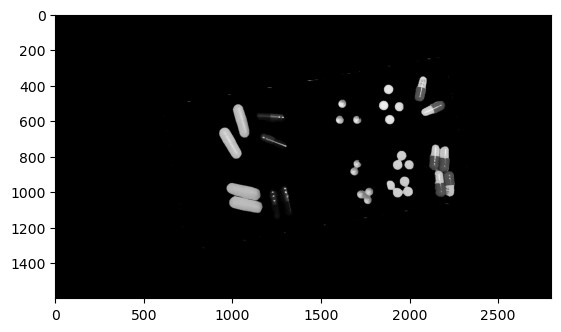

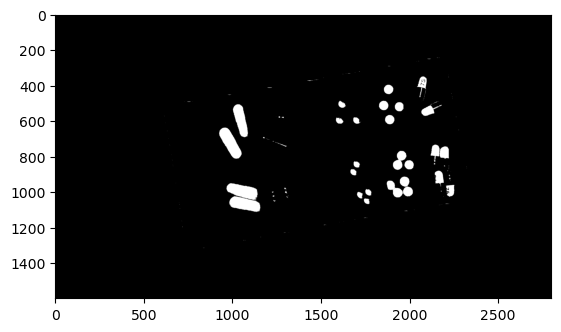

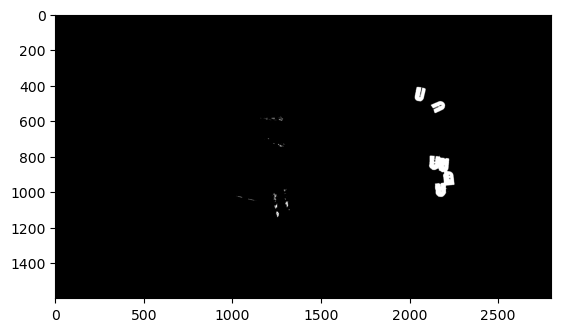

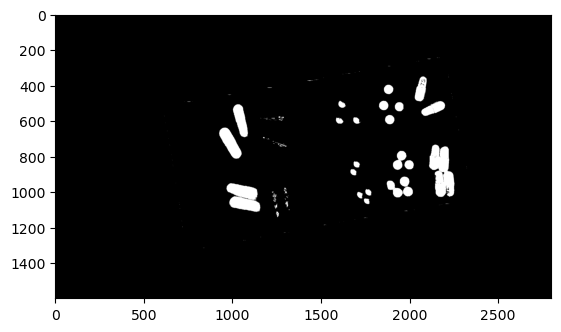

In [725]:
# image = calib.copy()

# masked = cv2.bitwise_and(image, image, mask=mask)
# plt.imshow(masked[..., ::-1])
# plt.show()

# find white elements in the image
lab_masked = cv2.cvtColor(masked, cv2.COLOR_BGR2LAB)

l = lab_masked[..., 0]
plt.imshow(l, cmap='gray')
plt.show()

_, mask = cv2.threshold(l, 160, 255, cv2.THRESH_BINARY)
plt.imshow(mask, cmap='gray')
plt.show()

hsv_masked = cv2.cvtColor(masked, cv2.COLOR_BGR2HSV)

red_mask = cv2.bitwise_or(cv2.inRange(hsv_masked, (0, 100, 20), (10, 255, 255)), cv2.inRange(hsv_masked, (170, 100, 20), (180, 255, 255)))

plt.imshow(red_mask, cmap='gray')
plt.show()


all_mask = cv2.bitwise_or(mask, red_mask)

plt.imshow(all_mask, cmap='gray')
plt.show()

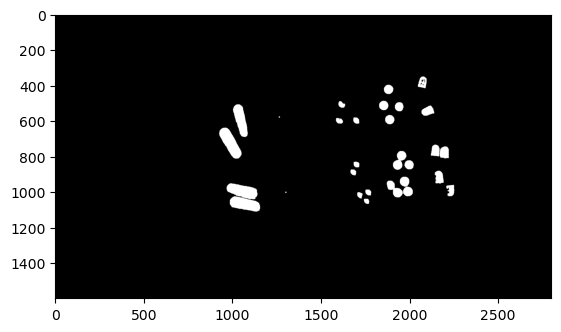

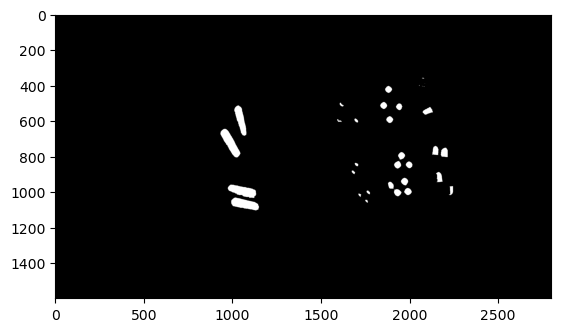

0.6607142857142857
0.6295294753921038
0.89404296875
0.6992861392028554
0.6849030470914127
0.7121875
0.689375
0.6315625
0.6994598765432098
0.6844181459566075
0.6735700197238659
1165.5
1164.0
915.5
1175.5
989.0
1139.5
1103.0
1010.5
906.5
1041.0
1024.5


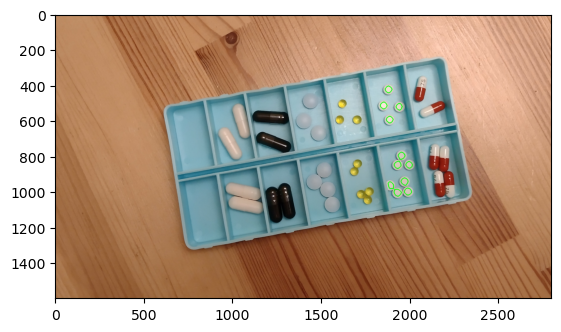

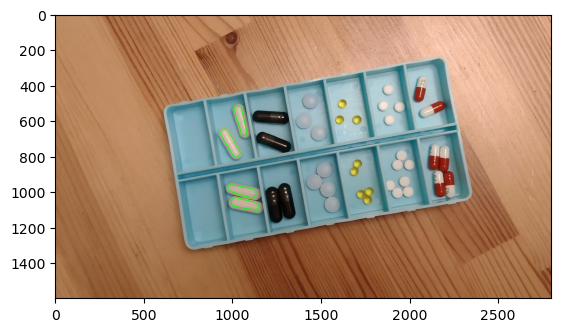

In [726]:
opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=3)
plt.imshow(opened, cmap='gray')
plt.show()

eroded = cv2.erode(mask, np.ones((3, 3), np.uint8), iterations=6)
plt.imshow(eroded, cmap='gray')
plt.show()

conts, _ = cv2.findContours(eroded, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

pills = [c for c in conts if 1500 > cv2.contourArea(c) > 500]


def logic_expression(c: Any) -> bool:
    x, y, w, h = cv2.boundingRect(c)
    area_sq = w**2
    area_c = cv2.contourArea(c)
    ratio = area_c / area_sq

    # ratio of perfect circle is 0.785

    return 0.9 > ratio > 0.6


pills = [c for c in pills if logic_expression(c)]

bbox = [cv2.boundingRect(c) for c in pills]

for i, (x, y, w, h) in enumerate(bbox):
    area_sq = w * w
    area_c = cv2.contourArea(pills[i])
    ratio = area_c / area_sq
    print(ratio)



for p in pills:
    print(cv2.contourArea(p))

image = calib.copy()
cv2.drawContours(image, pills, -1, (0, 255, 0), 3)
plt.imshow(image[..., ::-1])
plt.show()


conts, _ = cv2.findContours(eroded, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

pills = [c for c in conts if 9000 > cv2.contourArea(c) > 4000]

image = calib.copy()
cv2.drawContours(image, pills, -1, (0, 255, 0), 3)
plt.imshow(image[..., ::-1])
plt.show()

# Pill o/ box

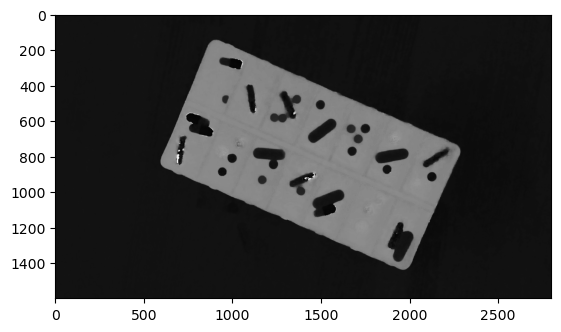

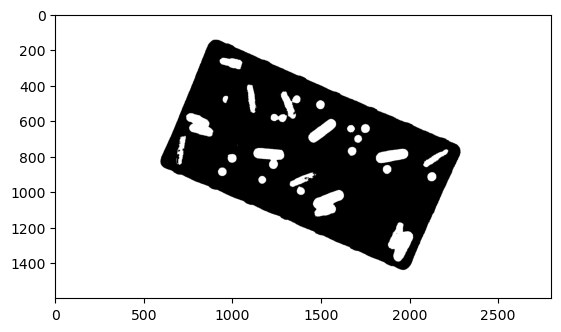

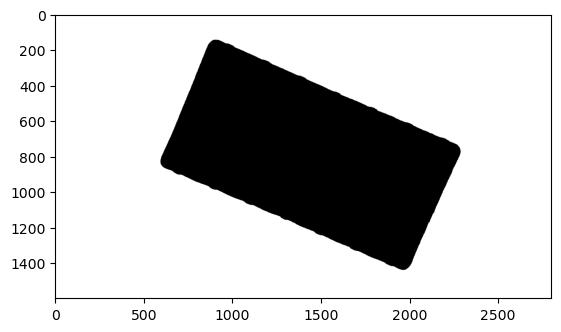

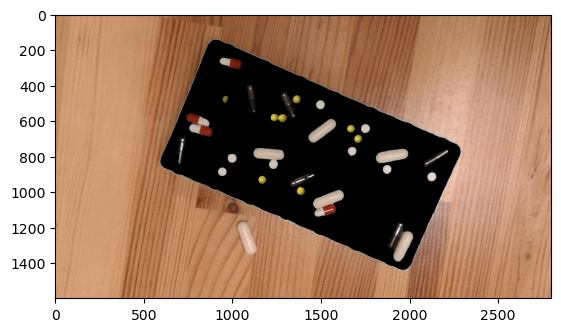

In [737]:
test_o_box = cv2.imread('Lab5_dane/test_line.png')
image = test_o_box.copy()

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h = hsv[..., 0]

plt.imshow(h, cmap='gray')
plt.show()

_, mask = cv2.threshold(h, 30, 255, cv2.THRESH_BINARY_INV)
plt.imshow(mask, cmap='gray')
plt.show()

# find countour of the black to crop the image

mask_only_box = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((11, 11), np.uint8), iterations=22)

plt.imshow(mask_only_box, cmap='gray')
plt.show()

masked = cv2.bitwise_and(image, image, mask=mask)

plt.imshow(masked[..., ::-1])
plt.show()


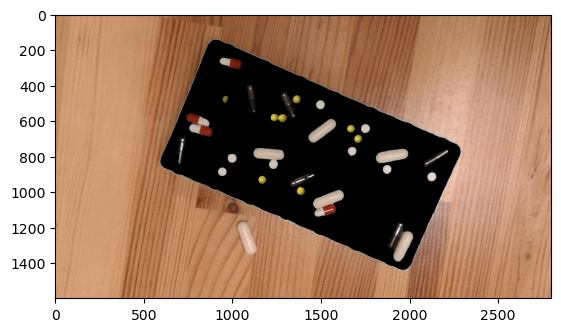

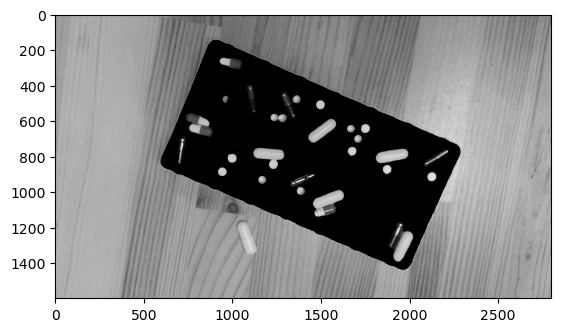

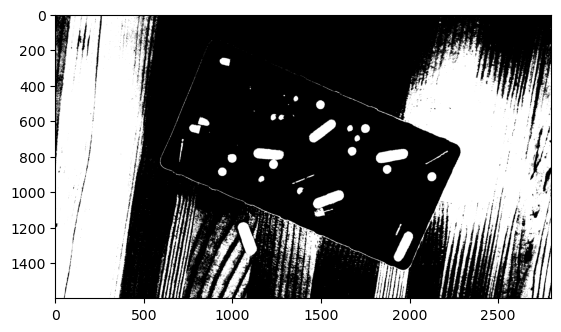

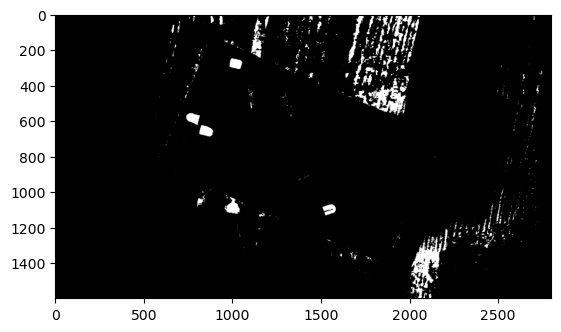

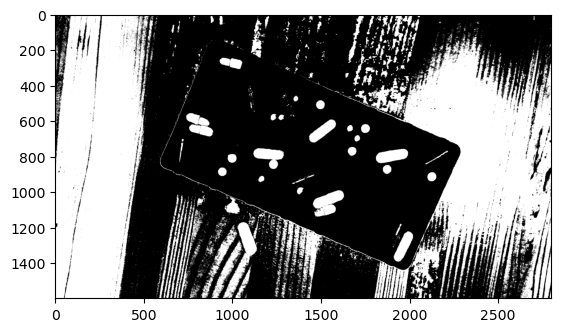

In [738]:
masked = cv2.bitwise_and(image, image, mask=mask)
plt.imshow(masked[..., ::-1])
plt.show()

# find white elements in the image
lab_masked = cv2.cvtColor(masked, cv2.COLOR_BGR2LAB)

l = lab_masked[..., 0]
plt.imshow(l, cmap='gray')
plt.show()

_, mask = cv2.threshold(l, 160, 255, cv2.THRESH_BINARY)
plt.imshow(mask, cmap='gray')
plt.show()

hsv_masked = cv2.cvtColor(masked, cv2.COLOR_BGR2HSV)

red_mask = cv2.bitwise_or(cv2.inRange(hsv_masked, (0, 100, 20), (10, 255, 255)), cv2.inRange(hsv_masked, (170, 100, 20), (180, 255, 255)))

plt.imshow(red_mask, cmap='gray')
plt.show()


all_mask = cv2.bitwise_or(mask, red_mask)

plt.imshow(all_mask, cmap='gray')
plt.show()

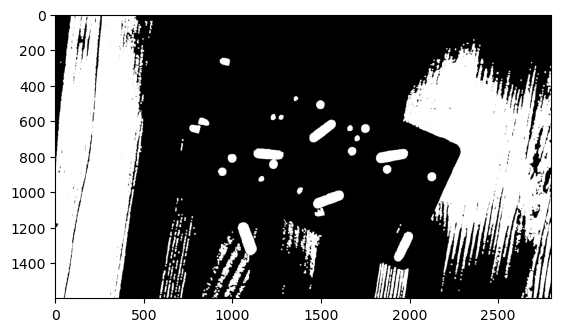

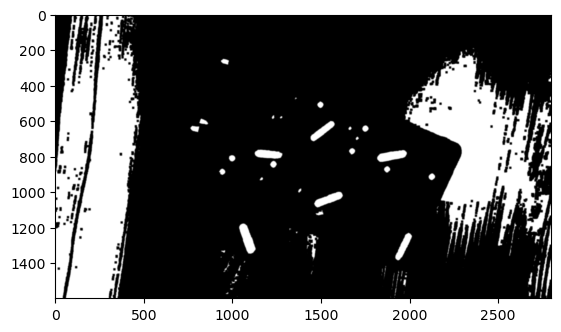

0.6379123850730124
0.7831632653061225
0.6859504132231405
0.6747448979591837
0.7166838842975206
0.7474173553719008
0.7032098765432099
0.7263374485596708
0.7661179698216736
0.8232
0.7246913580246913
0.8520710059171598
1179.5
614.0
747.0
529.0
1387.5
1447.0
1424.0
529.5
558.5
514.5
1467.5
576.0


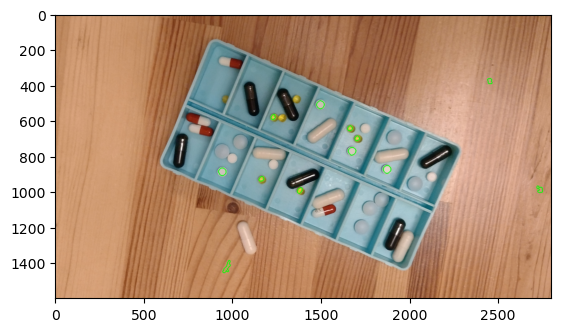

5295.0
7714.5
6925.0
8648.5
7759.0
8547.0
7593.0


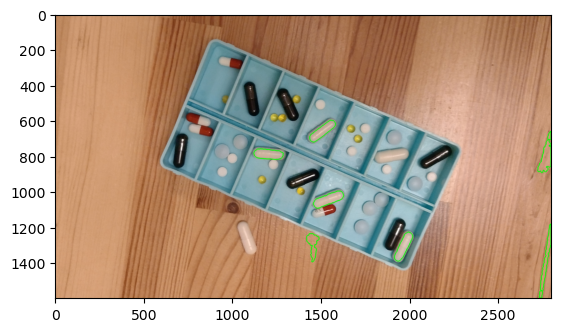

In [753]:
opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=3)
plt.imshow(opened, cmap='gray')
plt.show()

eroded = cv2.erode(mask, np.ones((3, 3), np.uint8), iterations=6)
plt.imshow(opened, cmap='gray')
plt.show()


conts, _ = cv2.findContours(eroded, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

pills = [c for c in conts if 1500 > cv2.contourArea(c) > 500]


def logic_expression(c: Any) -> bool:
    x, y, w, h = cv2.boundingRect(c)
    area_sq = w**2
    area_c = cv2.contourArea(c)
    ratio = area_c / area_sq

    # ratio of perfect circle is 0.785

    return 0.9 > ratio > 0.6


pills = [c for c in pills if logic_expression(c)]

bbox = [cv2.boundingRect(c) for c in pills]

for i, (x, y, w, h) in enumerate(bbox):
    area_sq = w * w
    area_c = cv2.contourArea(pills[i])
    ratio = area_c / area_sq
    print(ratio)



for p in pills:
    print(cv2.contourArea(p))

image = test_o_box.copy()
cv2.drawContours(image, pills, -1, (0, 255, 0), 3)
plt.imshow(image[..., ::-1])
plt.show()


conts, _ = cv2.findContours(eroded, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

pills = [c for c in conts if 9000 > cv2.contourArea(c) > 4000]

for p in pills:
    print(cv2.contourArea(p))

image = test_o_box.copy()
cv2.drawContours(image, pills, -1, (0, 255, 0), 3)
plt.imshow(image[..., ::-1])
plt.show()

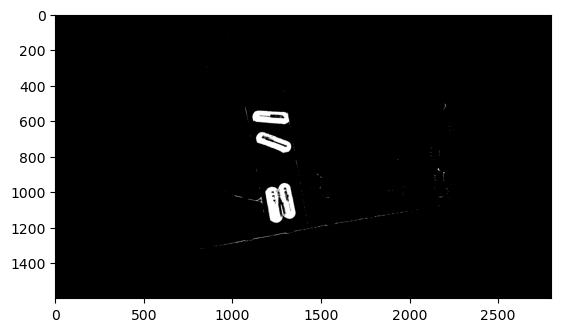

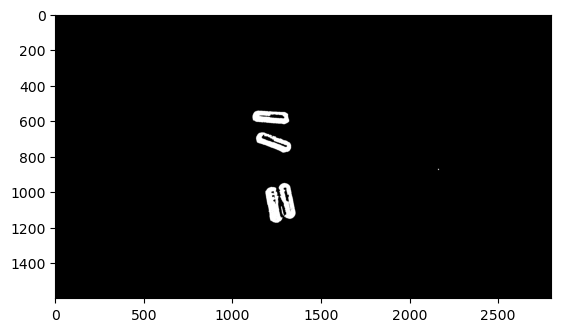

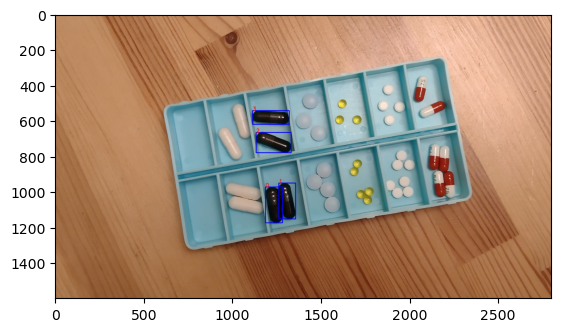

In [727]:
image = calib.copy()
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
v_org = hsv[..., 2]

_, v = cv2.threshold(v_org, 60, 255, cv2.THRESH_BINARY_INV)
_, blaclest = cv2.threshold(v_org, 7, 255, cv2.THRESH_BINARY)

v = cv2.bitwise_and(v, blaclest)
plt.imshow(v, cmap='gray')
plt.show()


v = cv2.morphologyEx(v, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=2)
plt.imshow(v, cmap='gray')
plt.show()

conts, _ = cv2.findContours(v, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

pills = [c for c in conts if cv2.contourArea(c) > 1000]

bbox = [cv2.boundingRect(c) for c in pills]

image = calib.copy()
for i, (x, y, w, h) in enumerate(bbox):
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)
    cv2.putText(image, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


plt.imshow(image[..., ::-1])

# BLUE PILL

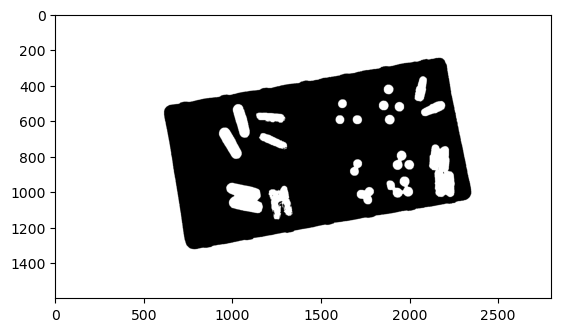

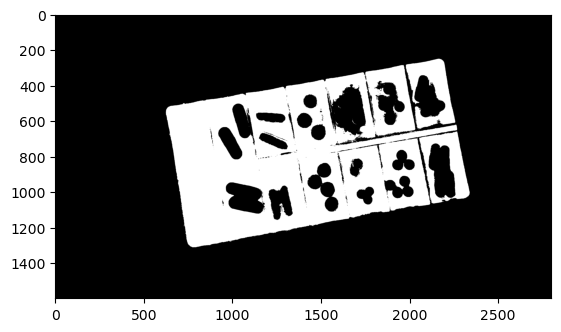

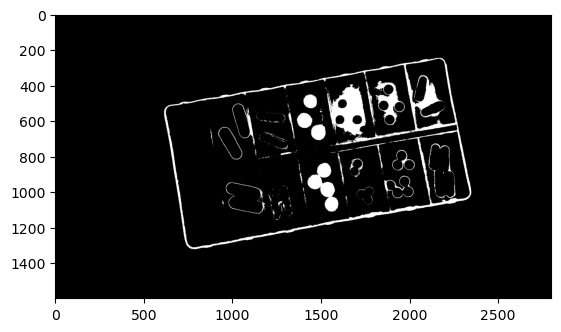

In [728]:
image = calib.copy()
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# plt.imshow(hsv[..., 0], cmap='gray')
# plt.show()

_, mask_h = cv2.threshold(hsv[..., 0], 50, 255, cv2.THRESH_BINARY_INV)
plt.imshow(mask_h, cmap='gray')
plt.show()

# _, mask_s = cv2.threshold(hsv[..., 1], 40, 255, cv2.THRESH_BINARY)
# plt.imshow(mask_s, cmap='gray')
# plt.show()

blue_mask = cv2.inRange(hsv, (60, 40, 0), (130, 255, 255))
plt.imshow(blue_mask, cmap='gray')
plt.show()


# mask_combined = cv2.bitwise_or(mask_h, mask_s)
# plt.imshow(mask_combined, cmap='gray')
# plt.show()

mask_combined = cv2.bitwise_or(mask_h, blue_mask)
mask_combined = cv2.bitwise_not(mask_combined)
plt.imshow(mask_combined, cmap='gray')
plt.show()


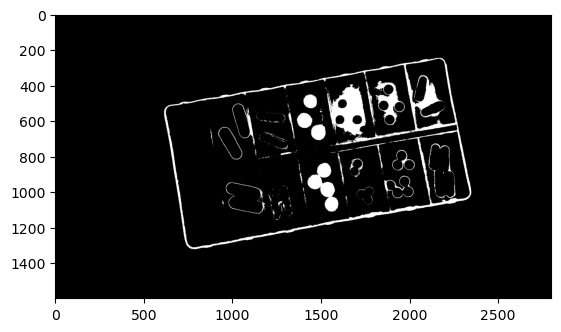

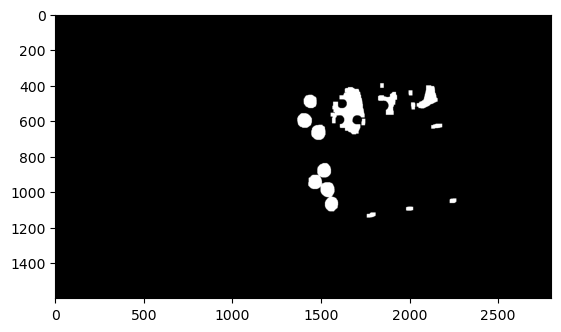

[[[1408  600   42]
  [1520  882   40]
  [1562 1072   40]
  [1468  946   41]
  [1490  666   43]
  [1542  988   44]
  [1442  490   40]
  [1706  598   29]
  [1618  504   28]
  [1606  598   28]]]


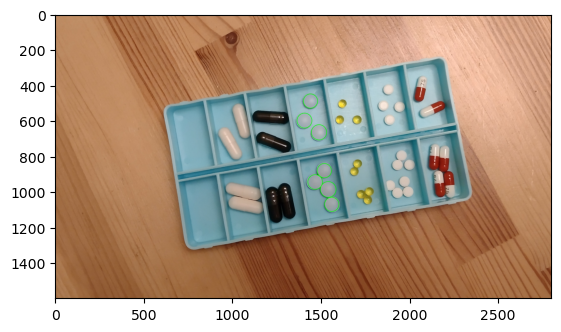

In [729]:
plt.imshow(mask_combined, cmap='gray')
plt.show()


opened = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=9)
plt.imshow(opened, cmap='gray')
plt.show()

circles = find_circles(opened, 25, 45)
circles = np.uint16(np.around(circles))

print(circles)

# if center of circle is white=1 then it is blue pill

circles = [c for c in circles[0] if opened[c[1], c[0]] == 255]


image = calib.copy()
for i in circles:
    cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
plt.imshow(image[..., ::-1])
plt.show()

